In [305]:
from plotly.offline import init_notebook_mode
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
init_notebook_mode(connected=True)

df=pd.read_excel('songs.xlsx')

In [306]:
df.head()

,artist,song,duration_minutes,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,3.519333,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,2.784433,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,rock
2,Faith Hill,Breathe,4.175767,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,pop
3,Bon Jovi,It's My Life,3.741550,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,rock
4,*NSYNC,Bye Bye Bye,3.342667,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [307]:
# Eilučių su popularity reikšmėmis <= 1 pašalinimas sumažina modelio vidutinę absoliutinę paklaidą nuo 15.51 iki 8.27
df = df[df.popularity > 1]

X = df.drop(['popularity'], axis=1)
y = df.popularity


print(y.unique())

y = np.round(y / 20)

print(y.unique())

X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=0)

[77 79 66 78 65 69 86 68 75 56 55 62 61 53 64 73 82 83 54 72 47 71 49 58
 52 59 36 43 60 63 70 57 76 74 50 42 48 67 26 46 51 30 45 87 27 85 40  2
 80 35 24 32 81 39  3 38 44 11 16 33 37 28  4 21 41 34 17 18  6 88 89 84
  8  7]
[4. 3. 2. 1. 0.]


<AxesSubplot:>

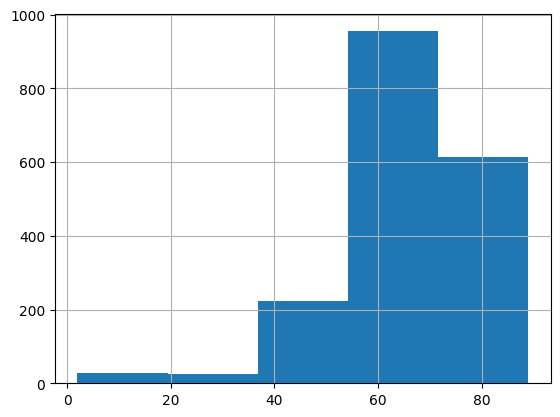

In [308]:
df['popularity'].hist(bins=5)


In [309]:
from scipy.stats.mstats import winsorize
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

class ExtremeValuesHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = winsorize(X, limits=[0.01, 0.01])
        return X_copy

class HeadPrinter(BaseEstimator, TransformerMixin):
    def __init__(self, comment):
        self.comment = comment
        self.cats = ['duration_minutes', 'year', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                           'genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8','genre_9','genre_10','genre_11','genre_12','explicit_false', 'explicit_true']
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = pd.DataFrame(X.copy(), columns=self.cats)
        print(self.comment)
        print(X_copy.head())
        return X

In [310]:
numeric_attributes = ['duration_minutes', 'year', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
categorical_attributes = ['genre', 'explicit']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean"))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_attributes),
    ('onehot', categorical_transformer, categorical_attributes)
])

In [311]:
tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('printer2', HeadPrinter("After converting categorical columns into numerical:")),
    ('extremes', ExtremeValuesHandler()),
    ('printer3', HeadPrinter("After handling extremes:")),
    ('scaler',  MinMaxScaler(feature_range=(0, 1))),
    ('printer4', HeadPrinter("After scaling:")),
    ('model', DecisionTreeClassifier(random_state=0))
])

tree_regressor = tree.fit(X_train, y_train)

predictions = tree_regressor.predict(X_valid)
print(mean_absolute_error(y_valid, predictions))



export_graphviz(tree['model'], out_file='tree.dot',feature_names=['duration_minutes', 'year', 'danceability', 'energy', 'key', 'loudness', 'speechiness', 
                                                                  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'genre_1', 'genre_2', 
                                                                  'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10', 
                                                                  'genre_11', 'genre_12', 'explicit_false', 'explicit_true'], 
                                                                  class_names=['very low', 'low', 'medium', 'high', 'very high'])
# dot -Tpdf tree.dot -o tree.pdf
cm = pd.DataFrame(confusion_matrix(y_valid,predictions))
cm

After converting categorical columns into numerical:
   duration_minutes    year  danceability  energy   key  loudness  \
0          3.930000  2004.0         0.629   0.532   5.0    -7.880   
1          3.698883  2007.0         0.736   0.740   0.0    -2.180   
2          4.679283  2015.0         0.383   0.430  10.0    -8.644   
3          3.980667  2004.0         0.734   0.668   0.0    -3.935   
4          3.748883  2003.0         0.680   0.847  11.0    -6.636   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0352        0.3310          0.000000    0.2380    0.619   90.098   
1       0.0786        0.5150          0.000000    0.0468    0.803  140.141   
2       0.0302        0.8170          0.000001    0.0869    0.174  107.005   
3       0.0349        0.0526          0.000000    0.0925    0.651   99.971   
4       0.1080        0.0217          0.000000    0.0374    0.750  176.051   

   genre_1  genre_2  genre_3  genre_4  genre_5  genre_6  genre_

,0,1,2,3,4
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,2,18,7
3,2,3,17,110,64
4,3,0,7,65,69


In [312]:
forest = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('printer2', HeadPrinter("After converting categorical columns into numerical:")),
    ('extremes', ExtremeValuesHandler()),
    ('printer3', HeadPrinter("After handling extremes:")),
    ('scaler',  MinMaxScaler(feature_range=(0, 1))),
    ('printer4', HeadPrinter("After scaling:")),
    ('model', RandomForestClassifier(random_state=0,n_estimators=7,max_depth=10))
])

forest_regressor = forest.fit(X_train, y_train)

predictions = forest_regressor.predict(X_valid)
print(mean_absolute_error(y_valid, predictions))

cm = pd.DataFrame(confusion_matrix(y_valid,predictions))
cm

After converting categorical columns into numerical:
   duration_minutes    year  danceability  energy   key  loudness  \
0          3.930000  2004.0         0.629   0.532   5.0    -7.880   
1          3.698883  2007.0         0.736   0.740   0.0    -2.180   
2          4.679283  2015.0         0.383   0.430  10.0    -8.644   
3          3.980667  2004.0         0.734   0.668   0.0    -3.935   
4          3.748883  2003.0         0.680   0.847  11.0    -6.636   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0       0.0352        0.3310          0.000000    0.2380    0.619   90.098   
1       0.0786        0.5150          0.000000    0.0468    0.803  140.141   
2       0.0302        0.8170          0.000001    0.0869    0.174  107.005   
3       0.0349        0.0526          0.000000    0.0925    0.651   99.971   
4       0.1080        0.0217          0.000000    0.0374    0.750  176.051   

   genre_1  genre_2  genre_3  genre_4  genre_5  genre_6  genre_

,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,1,20,6
3,0,0,2,143,51
4,0,0,0,67,77
